## Linear regression model to generate pricing for used smartphones

# Context

Buying and selling used smartphones used to be something that happened on a handful of online marketplace sites. But the used and refurbished phone market has grown considerably over the past decade, and a new IDC (International Data Corporation) forecast predicts that the used phone market would be worth \\$52.7bn by 2023 with a compound annual growth rate (CAGR) of 13.6% from 2018 to 2023. This growth can be attributed to an uptick in demand for used smartphones that offer considerable savings compared with new models.

Refurbished and used devices continue to provide cost-effective alternatives to both consumers and businesses that are looking to save money when purchasing a smartphone. There are plenty of other benefits associated with the used smartphone market. Used and refurbished devices can be sold with warranties and can also be insured with proof of purchase. Third-party vendors/platforms, such as Verizon, Amazon, etc., provide attractive offers to customers for refurbished smartphones. Maximizing the longevity of mobile phones through second-hand trade also reduces their environmental impact and helps in recycling and reducing waste. The impact of the COVID-19 outbreak may further boost the cheaper refurbished smartphone segment, as consumers cut back on discretionary spending and buy phones only for immediate needs.

 
# Objective

The rising potential of this comparatively under-the-radar market fuels the need for an ML-based solution to develop a dynamic pricing strategy for used and refurbished smartphones. ReCell, a startup aiming to tap the potential in this market, wants to analyze the data provided and build a linear regression model to predict the price of a used phone and identify factors that significantly influence it.

 
# Data Description
The data contains the different attributes of used/refurbished phones. The detailed data dictionary is given below.

**Data Dictionary**

- brand_name: Name of manufacturing brand
- os: OS on which the phone runs
- screen_size: Size of the screen in cm
- 4g: Whether 4G is available or not
- 5g: Whether 5G is available or not
- main_camera_mp: Resolution of the rear camera in megapixels
- selfie_camera_mp: Resolution of the front camera in megapixels
- int_memory: Amount of internal memory (ROM) in GB
- ram: Amount of RAM in GB
- battery: Energy capacity of the phone battery in mAh
- weight: Weight of the phone in grams
- release_year: Year when the phone model was released
- days_used: Number of days the used/refurbished phone has been used
- new_price: Price of a new phone of the same model in euros
- used_price: Price of the used/refurbished phone in euros

## Importing necessary libraries and data

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')
import math
# import sklearn package
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# to check model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# testing for linear regression assumptions
from statsmodels.stats.outliers_influence import variance_inflation_factor

# import alternative ols  package
from scipy.stats import pearsonr
from statsmodels.formula.api import ols
from statsmodels.graphics.gofplots import ProbPlot
import statsmodels.api as sm
from scipy import stats

## Data Overview

- Observations
- Sanity checks

In [115]:
# load the observations data
data = pd.read_csv('used_phone_data.csv')
recell_df = data.copy()

In [217]:
# set this flag False for first model simulation
# a list is created for statistically insignificant features
# set it True for the next run for optimization of the model
dropped = True

In [218]:
# randomly browse the data
recell_df.sample(n=10, random_state=1)

,brand_name,os,screen_size,4g,5g,main_camera_mp,selfie_camera_mp,int_memory,ram,battery,weight,release_year,days_used,new_price,used_price,used_price_log,new_price_log
1012,Celkon,Others,5.720,no,no,1.30,0.3,256.0,0.25,1400.0,140.00,2013.0,818.0,29.48000,8.70,2.163323,3.383712
2334,Panasonic,Android,13.490,no,no,13.00,2.0,32.0,4.00,2500.0,141.00,2014.0,996.0,218.70000,65.70,4.185099,5.387701
426,Alcatel,Android,17.780,yes,no,3.00,0.3,4.0,1.00,3240.0,240.75,2014.0,1046.0,191.21000,57.32,4.048650,5.253372
3017,Others,Android,13.810,yes,no,16.00,5.0,56.0,4.00,3000.0,162.00,2017.0,769.0,191.49000,76.63,4.338989,5.254836
2775,Others,Android,12.700,yes,no,8.00,1.2,32.0,4.00,2040.0,141.00,2014.0,1076.0,182.30000,54.63,4.000583,5.205654
1960,Micromax,Android,10.160,no,no,2.00,0.3,16.0,4.00,2000.0,146.50,2014.0,1032.0,69.24000,20.73,3.031582,4.237579
1208,HTC,Android,14.675,yes,no,13.00,10.5,56.0,4.00,3500.0,188.00,2018.0,384.0,473.18125,199.11,5.642195,6.438390
1245,HTC,Android,13.490,no,no,13.00,8.0,16.0,4.00,2600.0,154.50,2015.0,916.0,178.86000,53.73,3.983972,5.186603
1404,Huawei,Android,12.700,yes,no,13.00,5.0,16.0,4.00,4000.0,160.00,2015.0,631.0,187.83000,75.22,4.320417,5.235537
2668,Samsung,Android,20.320,yes,no,3.15,1.3,16.0,4.00,4450.0,267.00,2014.0,643.0,350.82000,140.30,4.943783,5.860273


In [219]:
recell_df.shape

(3561, 17)

In [220]:
# list numeric columns
numeric_columns = recell_df.select_dtypes(include=np.number).columns.tolist()
numeric_columns

['screen_size',
 'main_camera_mp',
 'selfie_camera_mp',
 'int_memory',
 'ram',
 'battery',
 'weight',
 'release_year',
 'days_used',
 'new_price',
 'used_price',
 'used_price_log',
 'new_price_log']

In [221]:
recell_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3561 entries, 0 to 3570
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   brand_name        3561 non-null   category
 1   os                3561 non-null   category
 2   screen_size       3561 non-null   float64 
 3   4g                3561 non-null   category
 4   5g                3561 non-null   category
 5   main_camera_mp    3561 non-null   float64 
 6   selfie_camera_mp  3561 non-null   float64 
 7   int_memory        3561 non-null   float64 
 8   ram               3561 non-null   float64 
 9   battery           3561 non-null   float64 
 10  weight            3561 non-null   float64 
 11  release_year      3561 non-null   float64 
 12  days_used         3561 non-null   float64 
 13  new_price         3561 non-null   float64 
 14  used_price        3561 non-null   float64 
 15  used_price_log    3561 non-null   float64 
 16  new_price_log     3561 n

### There are 11 numeric variables and 4 non-numeric variables

## EDA For Preprocessing: To identify missing values and outliers. Missing values will be replaced using the mean or median values of features - each will be tried during regression modelling phase. Outliers will be replaced by defining a floor and ceiling based on the IQR.

In [222]:
# Find the number of missing values
missing = recell_df.isna().sum()
total_missing = sum(recell_df.isna().sum())
print(f"There are {total_missing} total missing values.")

There are 0 total missing values.


In [223]:
percentmissing = (total_missing/(data.shape[0]*data.shape[1])) * 100.0

In [224]:
print(f"{round(percentmissing,2)} percent of data missing - less than 1 percent of total data.")

0.0 percent of data missing - less than 1 percent of total data.


In [225]:
# get a breakdown of missing values - ie by feature
missing

brand_name          0
os                  0
screen_size         0
4g                  0
5g                  0
main_camera_mp      0
selfie_camera_mp    0
int_memory          0
ram                 0
battery             0
weight              0
release_year        0
days_used           0
new_price           0
used_price          0
used_price_log      0
new_price_log       0
dtype: int64

### Only numeric type variables have missing values

In [226]:
# main_camera_mp is the feature with the largest amount of missing values
# get the breakdown by brand

# get a list of main_camera_mp value counts by phone brand
main_camera_mp_val_cnts_by_phone = recell_df.groupby('brand_name').main_camera_mp.value_counts(dropna=False)

missing_main_camera_mp_values_by_phone = []
# create a list of tuple with phone brand and number of missing main_camera_mp values
for phone in recell_df.brand_name.unique():  
    for mp, count in enumerate(main_camera_mp_val_cnts_by_phone[phone]):
      if (math.isnan(main_camera_mp_val_cnts_by_phone[phone].index[mp])):
        missing_main_camera_mp_values_by_phone.append((phone, count))
            
    

In [227]:
print(f'There are {recell_df.brand_name.nunique()} number of phone brands\n\
and {len(missing_main_camera_mp_values_by_phone)} are missing main_camera_mp values.')
missing_main_camera_mp_values_by_phone

There are 33 number of phone brands
and 0 are missing main_camera_mp values.


[]

In [228]:
# this code fragment generates list of pnone brands that are missing main_camera_mp values
# We will drop phones missing all values for main_camera_mp because we want to minimize the level of bias we add to
# the data when we replace the missing values by either mean or median values
phones_missing_all_values = []
for brand_missing in missing_main_camera_mp_values_by_phone:
    if ((recell_df[recell_df['brand_name'] == brand_missing[0]].shape[0]) == (brand_missing[1])):
           phones_missing_all_values.append(brand_missing[0])


In [229]:
phones_missing_all_values

[]

In [230]:
# the Infinix brand does not have any values for the main_camera_mp and only 
# has a total of 10 rows in the sample data set. main_camera_mp is an important
# feature that impacts the value of a camera so the Infinix data rows will
# be deleted
recell_df.drop(recell_df[recell_df.brand_name == 'Infinix'].index, inplace=True)

In [231]:
recell_df.describe().T

,count,mean,std,min,25%,50%,75%,max
screen_size,3561.0,14.571474,4.717890,2.860000,12.700000,13.490000,16.030000,32.39000
main_camera_mp,3561.0,9.533627,4.465917,0.080000,5.000000,10.500000,13.000000,23.00000
selfie_camera_mp,3561.0,6.285299,6.344746,0.300000,2.000000,5.000000,8.000000,32.00000
int_memory,3561.0,43.986129,47.628652,0.005000,16.000000,32.000000,56.000000,512.00000
ram,3561.0,4.060893,1.389051,0.030000,4.000000,4.000000,4.000000,16.00000
battery,3561.0,3018.567256,1225.010176,205.000000,2100.000000,3000.000000,4000.000000,9720.00000
weight,3561.0,168.399410,57.258878,25.000000,140.000000,159.000000,183.000000,713.00000
release_year,3561.0,2015.948364,2.285967,2013.000000,2014.000000,2015.000000,2018.000000,2020.00000
days_used,3561.0,676.474516,247.802043,91.000000,539.000000,691.000000,872.000000,1094.00000
new_price,3561.0,226.374164,153.137443,9.130000,120.220000,189.840000,292.080000,1499.07000


In [232]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [233]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [234]:
# get the breakdown of main_camera_mp observations in mega pizels with null values by brand name
recell_df[recell_df.main_camera_mp.isna()].value_counts('brand_name')
print(f"{sum(recell_df[recell_df.main_camera_mp.isna()].value_counts('brand_name'))} main_camera_mp values are missing")

0 main_camera_mp values are missing


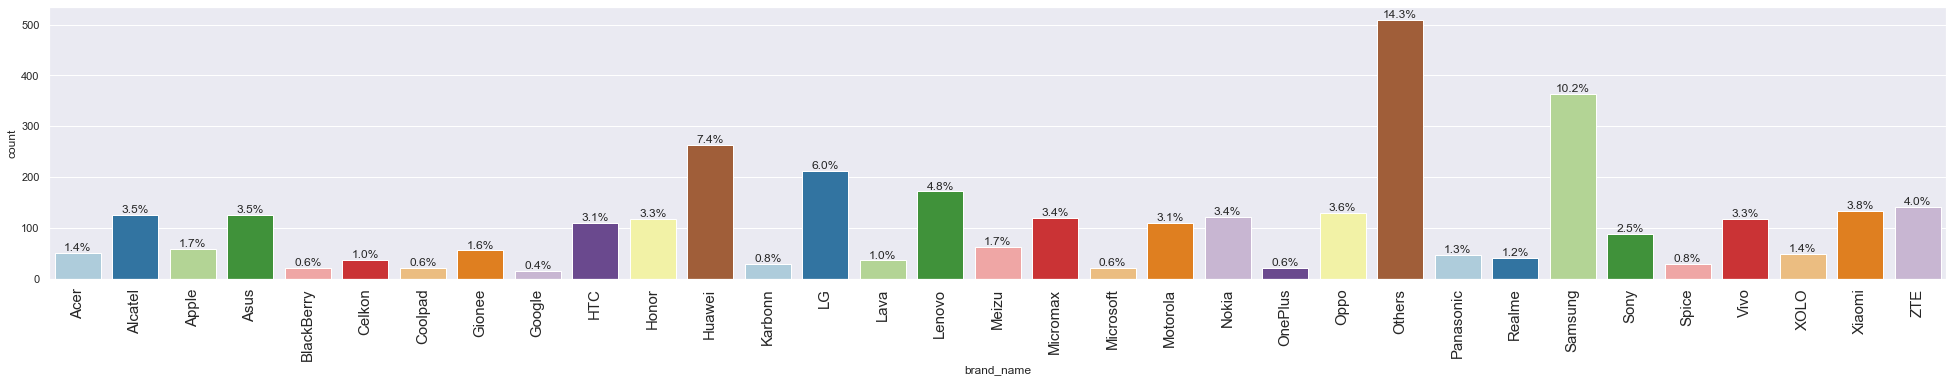

In [235]:
# plot the percentage of phones by brand

labeled_barplot(recell_df, "brand_name", perc=True)

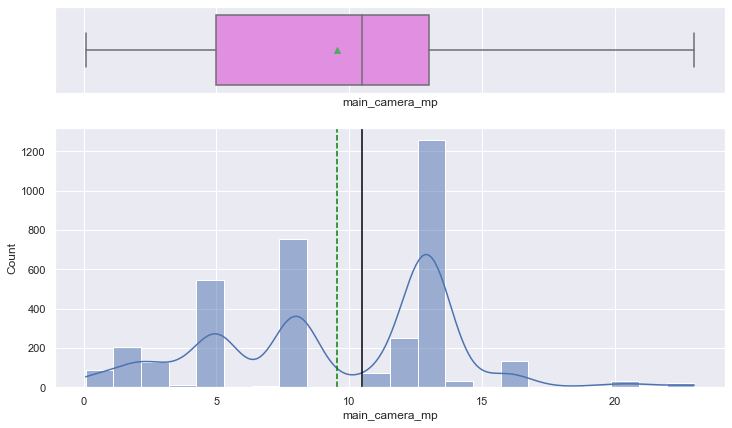

In [236]:
histogram_boxplot(recell_df, 'main_camera_mp', figsize=(12, 7), kde=True, bins=None)

## Data Preprocessing

- Missing value treatment
- Feature engineering (if needed)
- Outlier detection and treatment (if needed)
- Preparing data for modeling
- Any other preprocessing steps (if needed)

### All the missing values will be replaced by mean or median of feature. The efficacy of both will be tested in the regression analysis

In [237]:
# reset original sample values
recell_df = data.copy()

In [238]:
# the Infinix brand does not have any values for the main_camera_mp and only 
# has a total of 10 rows in the sample data set. main_camera_mp is an important
# feature that impacts the value of a camera so the Infinix data rows will
# be deleted
recell_df.drop(recell_df[recell_df.brand_name == 'Infinix'].index, inplace=True)

In [239]:
# function to replace null values in columns
# df - the DataFrame
# select_criteria - single column used to filter out a subset of rows from  a missing column
# e.g. brand_name in our data set
# missing - array of features whose missing values are to be replaced

def replaceNulls(df, select_criteria, missingfeatures, useMean=True):    
    for rowvalue in df[select_criteria].unique():
        for feature in missingfeatures:
            if useMean == True:
                df.loc[((df[select_criteria] == rowvalue) \
                              & (pd.isna(df[feature]))), feature] \
                                = df.groupby(select_criteria)[feature].mean()[rowvalue]
            else:
                df.loc[((df[select_criteria] == rowvalue) \
                              & (pd.isna(df[feature]))), feature] \
                                = df.groupby(select_criteria)[feature].median()[rowvalue]
                

In [240]:
# get the list of features with missing values
missing_or_not = recell_df.isna().sum()
cols_with_missing_values = [missing_or_not.index[x] for x,y in enumerate(missing_or_not) if y != 0]
# get break down of missing values by feature
sobj = pd.Series({col:recell_df[col].isna().value_counts()[1] for col in cols_with_missing_values})
sobj.sort_values(ascending=False)

print(sobj)

main_camera_mp      170
selfie_camera_mp      2
int_memory           10
ram                  10
battery               6
weight                7
dtype: int64


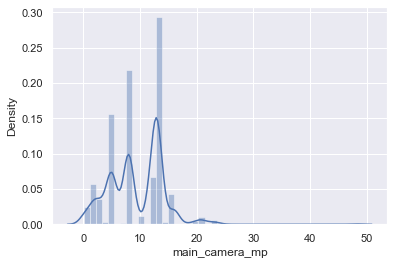

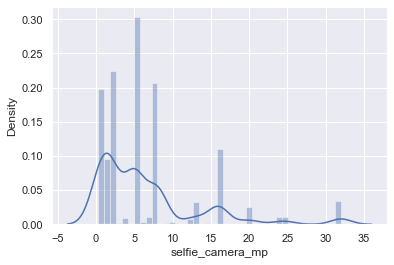

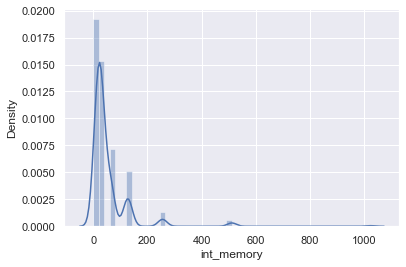

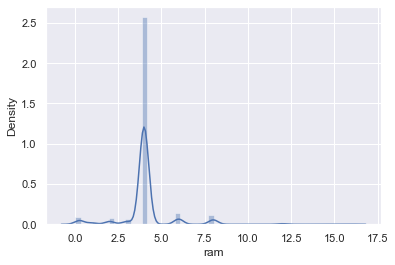

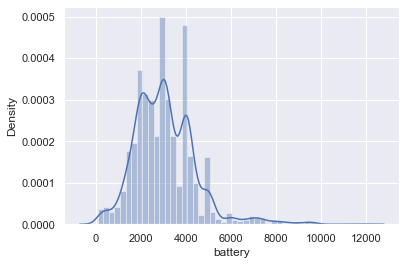

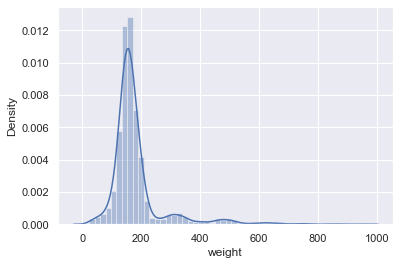

In [241]:
for feature in cols_with_missing_values:
    sns.distplot(recell_df[feature])
    plt.show()

## Some of the features in our sample data have skewed distributions therefore we will first attempt to replace the missing values with corresponding median values.

In [242]:
replaceNulls(recell_df, "brand_name", cols_with_missing_values, useMean=False)

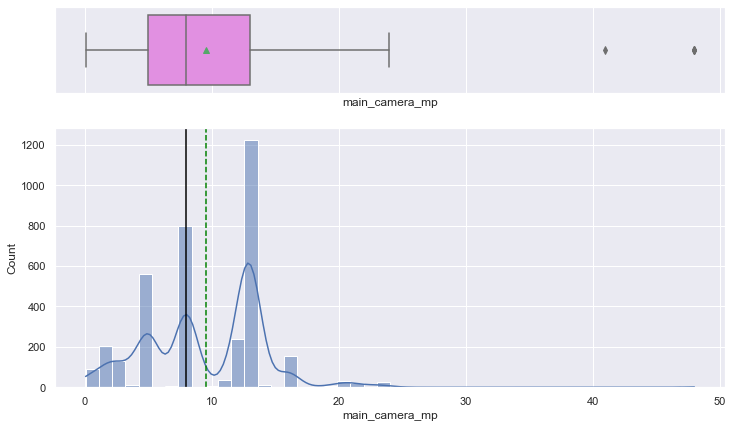

In [243]:
histogram_boxplot(recell_df, 'main_camera_mp', figsize=(12, 7), kde=True, bins=None)

In [244]:
# Verify there are no longer missing values
missing = recell_df.isna().sum()
total_missing = sum(recell_df.isna().sum())
print(f"There are {total_missing} total missing values.")

There are 0 total missing values.


In [245]:
# browse data set randomly and verify there are no nans
recell_df.sample(n=10)

,brand_name,os,screen_size,4g,5g,main_camera_mp,selfie_camera_mp,int_memory,ram,battery,weight,release_year,days_used,new_price,used_price
755,Asus,Android,13.49,yes,no,13.00,8.0,32.0,4.00,5000.0,181.0,2017,754,220.61,88.18
1677,Lenovo,Android,12.70,no,no,13.00,5.0,16.0,4.00,2000.0,121.0,2013,986,420.54,126.15
1590,Lenovo,Android,12.70,yes,no,5.00,2.0,32.0,4.00,2300.0,166.0,2016,569,90.29,44.99
3076,Xiaomi,Android,12.70,yes,no,13.00,5.0,32.0,4.00,4100.0,156.0,2016,734,160.66,64.33
1398,Huawei,Android,13.02,yes,no,12.00,8.0,32.0,4.00,3000.0,144.0,2016,551,340.34,170.24
400,Others,Android,21.75,yes,no,8.00,0.3,16.0,2.00,2000.0,374.0,2013,1064,281.23,84.24
2415,Others,Android,23.02,no,no,3.15,0.3,512.0,0.25,2100.0,150.0,2014,818,61.29,18.38
2843,Sony,Android,11.43,no,no,8.00,0.3,32.0,4.00,2300.0,148.0,2014,962,180.82,54.19
1605,Lenovo,Android,12.70,yes,no,8.00,2.0,32.0,4.00,2300.0,140.0,2015,697,108.10,43.32
3101,Xiaomi,Android,13.81,yes,no,13.00,4.0,16.0,4.00,3000.0,161.0,2015,902,189.82,57.01


## EDA For Regression Modelling

1. What does the distribution of used phone prices look like?
2. What percentage of the used phone market is dominated by Android devices?
3. The amount of RAM is important for the smooth functioning of a phone. How does the amount of RAM vary with the brand?
4. A large battery often increases a phone's weight, making it feel uncomfortable in the hands. How does the weight vary for phones offering large batteries (more than 4500 mAh)?
5. Bigger screens are desirable for entertainment purposes as they offer a better viewing experience. How many phones are available across different brands with a screen size larger than 6 inches?
6. Budget phones nowadays offer great selfie cameras, allowing us to capture our favorite moments with loved ones. What is the distribution of budget phones offering greater than 8MP selfie cameras across brands?
7. Which attributes are highly correlated with the used phone price?

### 1. What does the distribution of used phone prices look like?

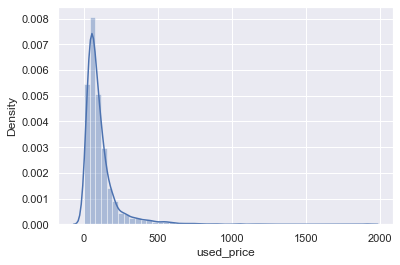

In [246]:
sns.distplot(recell_df['used_price'])
plt.show()

### The distribution of used phone prices is skewed towards the right

### 2. What percentage of the used phone market is dominated by Android devices?

In [247]:
perc = ((recell_df['os'].value_counts()[0]) / (recell_df['os'].value_counts().sum())) * 100
print(f"Android has {np.round(perc,2)}% of the used phone market." )

Android has 90.87% of the used phone market.


### Because Android dominates the market, our model for used phone pricing will be mostly determined by the Android data.

In [248]:
recell_df['os'].value_counts()

Android    3236
Others      202
Windows      67
iOS          56
Name: os, dtype: int64

### 3. The amount of RAM is important for the smooth functioning of a phone. How does the amount of RAM vary with the brand?

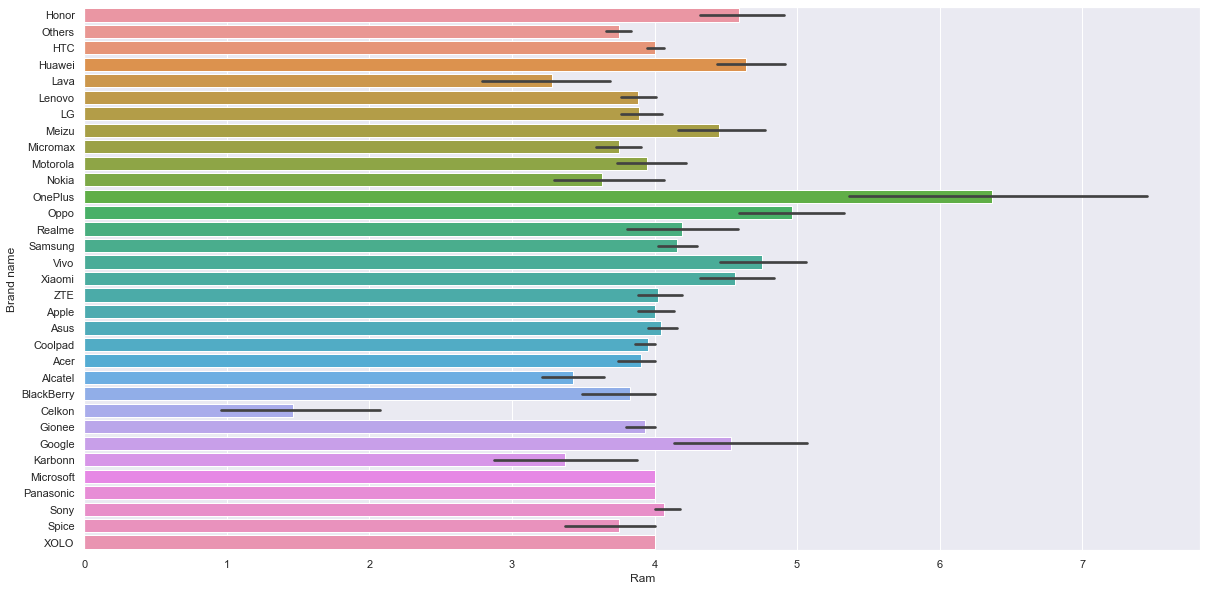

In [249]:
plt.figure(figsize=(20,10))
sns.barplot(data=recell_df, x="ram", y="brand_name")
plt.ylabel('Brand name')
plt.xlabel('Ram')
plt.show()

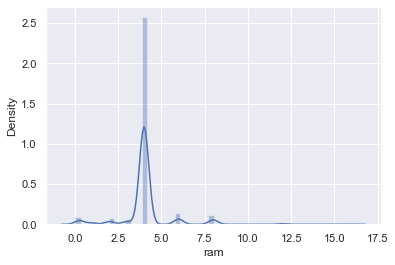

In [250]:
sns.distplot(recell_df.ram)
plt.show()

### Although outliers exist, the amount of RAM accross brands is normaly distributed with the mean and median values approximately 4 GB

### 4. A large battery often increases a phone's weight, making it feel uncomfortable in the hands. How does the weight vary for phones offering large batteries (more than 4500 mAh)?

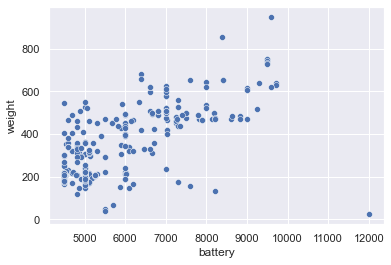

In [251]:
sns.scatterplot(data=recell_df, x=recell_df[recell_df['battery'] >= 4500.0].battery, y="weight")
plt.show()

### The battery weight increases as its capacity increases

### 5. Bigger screens are desirable for entertainment purposes as they offer a better viewing experience. How many phones are available across different brands with a screen size larger than 6 inches?

In [252]:
print (f"There are {recell_df[recell_df.screen_size > 6.0].shape[0]} phones with 6 or more indf_budgetches of screen width.")

There are 3440 phones with 6 or more indf_budgetches of screen width.


### 6. Budget phones nowadays offer great selfie cameras, allowing us to capture our favorite moments with loved ones. What is the distribution of budget phones offering greater than 8MP selfie cameras across brands?

In [253]:
budgetprice = recell_df['new_price'].median()
print(f"{budgetprice} is the median price for phones accross brands.")
print(f"Phones that cost not more than {budgetprice} will be considered budget. ")

189.86 is the median price for phones accross brands.
Phones that cost not more than 189.86 will be considered budget. 


In [254]:
df_budget = recell_df[(recell_df['selfie_camera_mp'] > 8.0) & (recell_df['new_price'] <= budgetprice)]

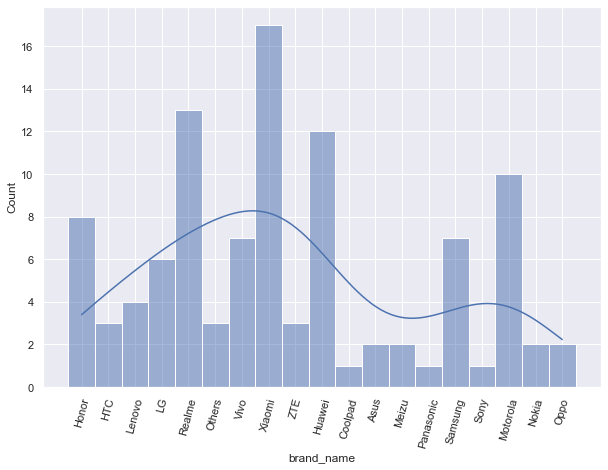

In [255]:
plt.figure(figsize=(10,7))
plt.xticks(rotation=75)
sns.histplot(df_budget['brand_name'], kde=True)
plt.show()

In [256]:
recell_df[recell_df.select_dtypes(include='number').columns.to_list()]

,screen_size,main_camera_mp,selfie_camera_mp,int_memory,ram,battery,weight,release_year,days_used,new_price,used_price
0,23.97,13.0,5.0,64.0,3.0,3020.0,146.0,2020,127,111.6200,86.96
1,28.10,13.0,16.0,128.0,8.0,4300.0,213.0,2020,325,249.3900,161.49
2,24.29,13.0,8.0,128.0,8.0,4200.0,213.0,2020,162,359.4700,268.55
3,26.04,13.0,8.0,64.0,6.0,7250.0,480.0,2020,345,278.9300,180.23
4,15.72,13.0,8.0,64.0,3.0,5000.0,185.0,2020,293,140.8700,103.80
...,...,...,...,...,...,...,...,...,...,...,...
3566,15.88,13.0,8.0,64.0,6.0,5000.0,190.0,2019,232,654.5000,490.96
3567,15.24,13.0,8.0,128.0,8.0,4000.0,200.0,2018,541,518.8145,259.30
3568,18.73,13.0,5.0,32.0,3.0,4000.0,165.0,2020,201,92.6500,69.81
3569,18.73,13.0,5.0,32.0,2.0,4000.0,160.0,2020,149,101.9150,76.07


### 7. Which attributes are highly correlated with the used phone price?

In [257]:
df_corr = recell_df[recell_df.select_dtypes(include='number').columns.to_list()].corr()
highly_correlated_features = [df_corr['used_price'].index[idx] for idx, hc in enumerate(df_corr['used_price']) if hc >= 0.7]
parts = highly_correlated_features[0].split('_')
print(f"The {parts[0]} {parts[1]} is is highly correlated to the old price.")

The new price is is highly correlated to the old price.


### EDA - Univariate Analysis

**Observations**


- The distribution of used phone prices is heavily right-skewed, with a mean value of ~100 euros.
- Let's apply the log transform to see if we can make the distribution closer to normal.

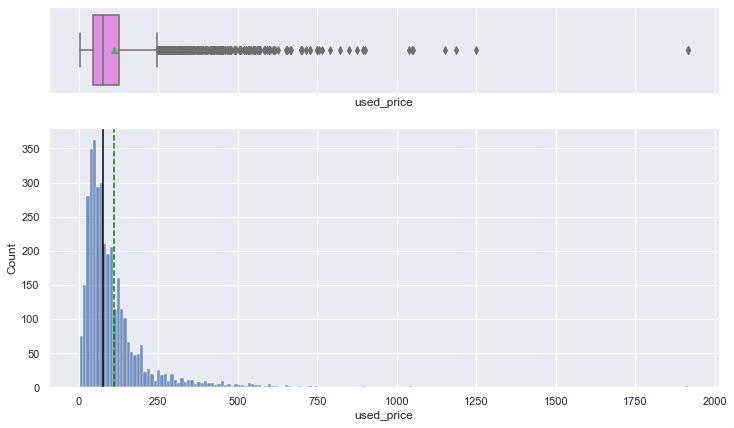

In [258]:
histogram_boxplot(recell_df, "used_price")

**Observations**

- The distribution of used phone prices is heavily right-skewed, with a mean value of ~100 euros.
- Let's apply the log transform to see if we can make the distribution closer to normal.


In [259]:
recell_df["used_price_log"] = np.log(recell_df["used_price"])

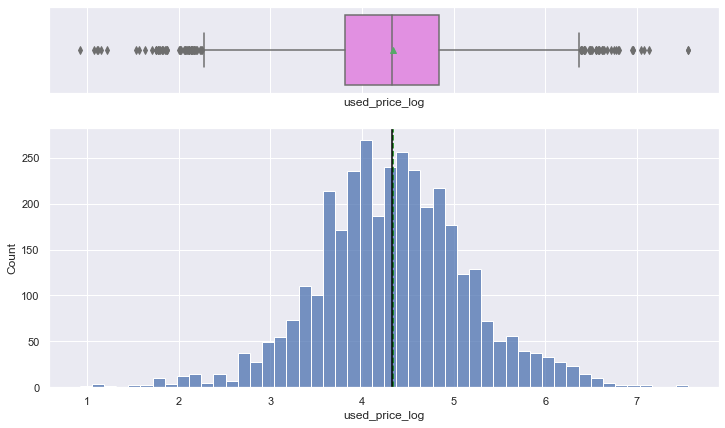

In [260]:
histogram_boxplot(recell_df, "used_price_log")

- The used phone prices are almost normally distributed now.

**`new_price`**

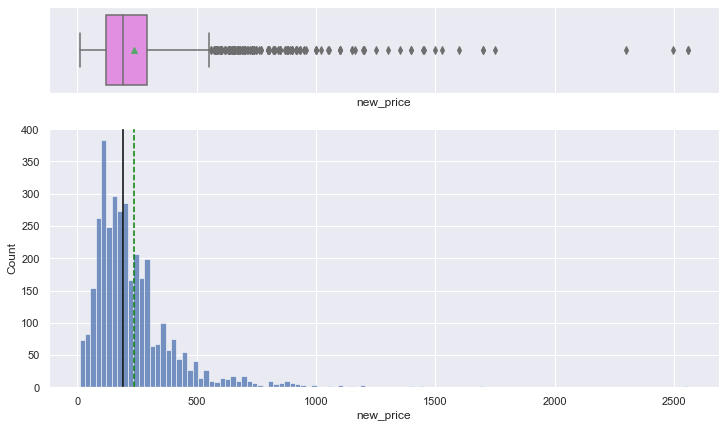

In [261]:
histogram_boxplot(recell_df, "new_price")

**Observations**

- The distribution is heavily right-skewed, with a mean value of ~200 euros.
- Let's apply the log transform to see if we can make the distribution closer to normal.

In [262]:
# let's apply the log transform to see if we can make the distribution of new_price closer to normal
recell_df["new_price_log"] = np.log(recell_df["new_price"])

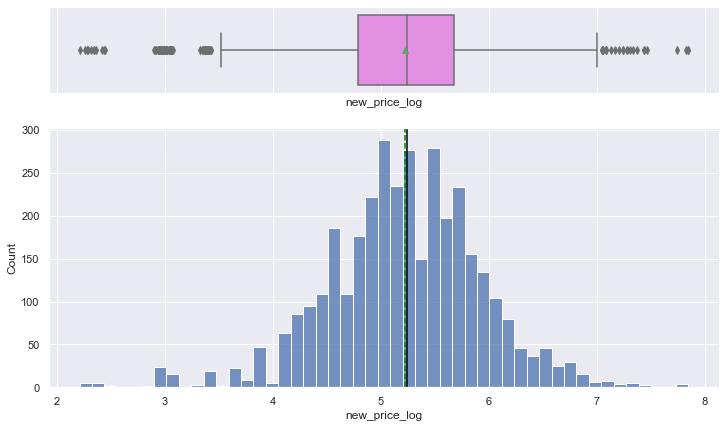

In [263]:
histogram_boxplot(recell_df, "new_price_log")

- The prices of new phone models are almost normally distributed now.

## EDA For Outlier Treatment
### It is a good idea to explore data before and after treatment

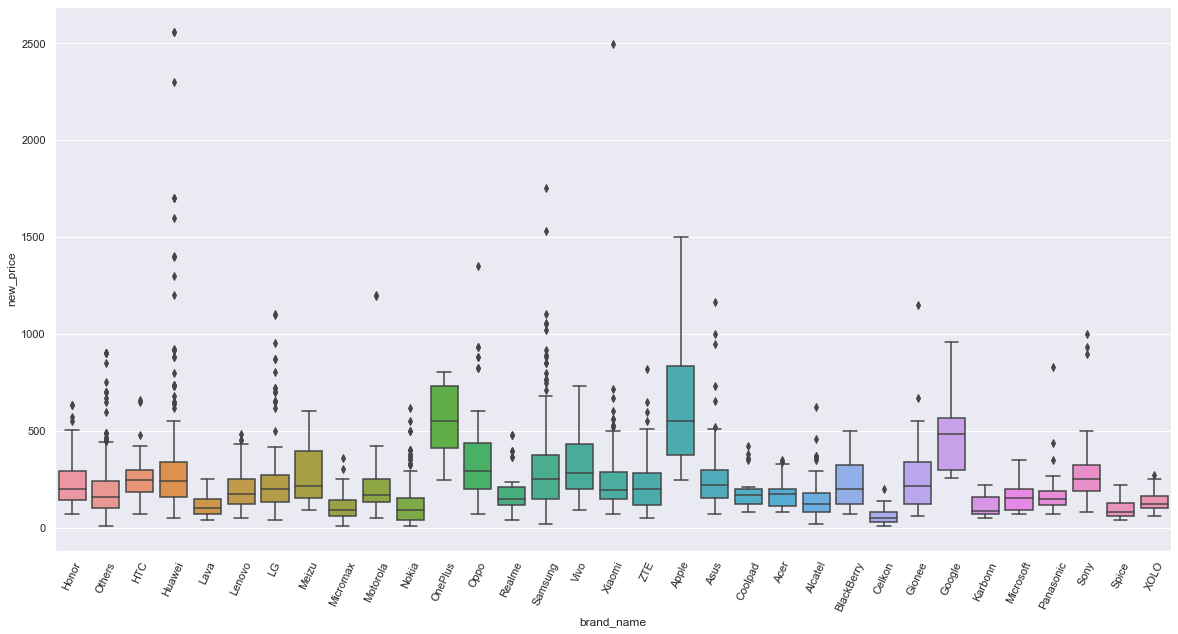

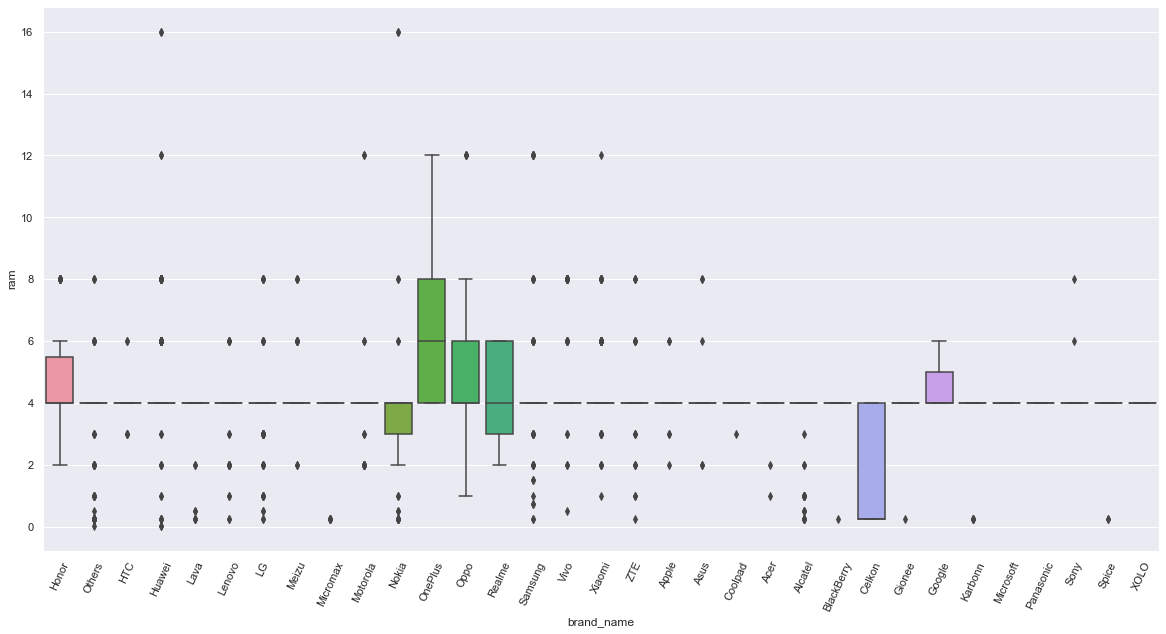

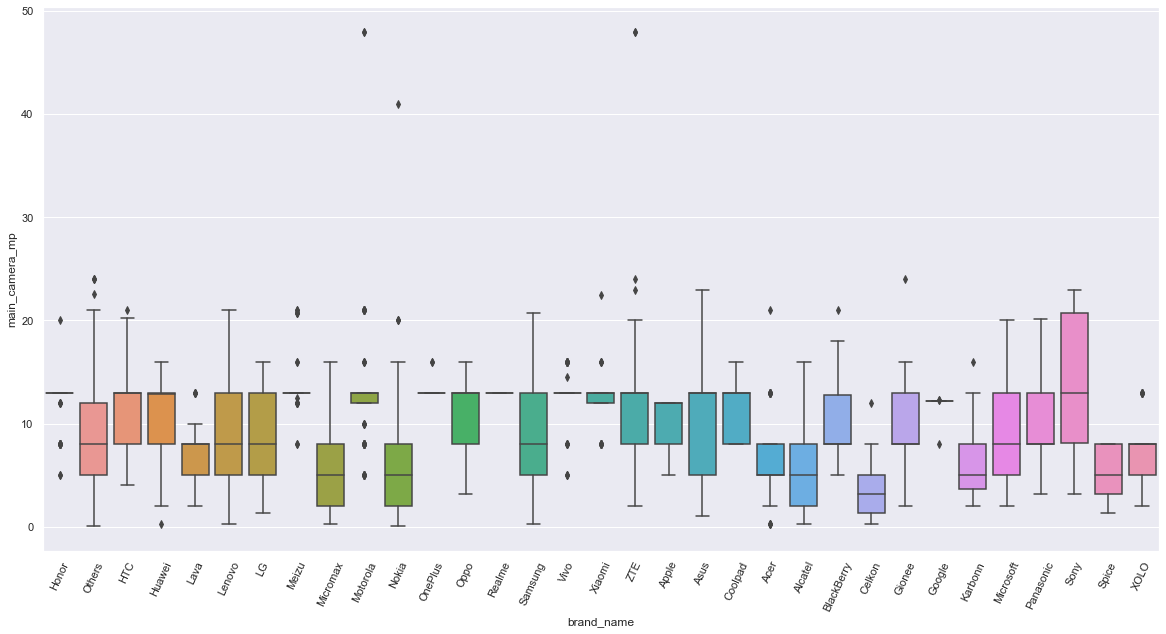

In [264]:
plt.figure(figsize=(20,10))
sns.boxplot(data=recell_df, x=recell_df['brand_name'], y=recell_df['new_price'])
plt.xticks(rotation=65)
plt.show()

plt.figure(figsize=(20,10))
sns.boxplot(data=recell_df, x=recell_df['brand_name'], y=recell_df['ram'])
plt.xticks(rotation=65)
plt.show()

plt.figure(figsize=(20,10))
sns.boxplot(data=recell_df, x=recell_df['brand_name'], y=recell_df['main_camera_mp'])
plt.xticks(rotation=65)
plt.show()

### There are many outliers in our data accross features and brands therefore we need to treat them if necessary. The strategy will be to create a model without treatment and ultimately compare it with one with treatment.

## Outlier Treatment - We shall initially perform our regression without outliers.

In [265]:
def treat_outliers(df, col):
    """
    treats outliers in a variable
    col: str, name of the numerical variable
    df: dataframe
    col: name of the column
    """
    Q1 = df[col].quantile(0.25)  # 25th quantile
    Q3 = df[col].quantile(0.75)  # 75th quantile
    IQR = Q3 - Q1
    Lower_Whisker = Q1 - 1.5 * IQR
    Upper_Whisker = Q3 + 1.5 * IQR
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker)

    return df


def treat_outliers_all(df, col_list):
    """
    treat outlier in all numerical variables
    col_list: list of numerical variables
    df: data frame
    """
    for c in col_list:
        df = treat_outliers(df, c)

    return df


## When missing values were replaced, it was done on a brand_name basis using median values of the feature given and the specified brand. 

## However, for Outlier Treatment, we will be using data accross brands. Our lower and upper bound values will correspond to the Lower and Upper whisker Boxplot values.

## No Outlier treatment will be applied to the ram feature because it changed the distribution of the data from pseudo normal to uniform and had negative impact on the regression

In [266]:
# 1. Outlier Treatment by brand
# for each phone brand, treating the outliers - applied only to numeric columns

numerical_col = recell_df.select_dtypes(include=np.number).columns.tolist()

for phone in recell_df.brand_name.unique(): 
        for feature in numerical_col:
            if (feature == 'ram'):
                continue
            sobj = treat_outliers(recell_df[recell_df.brand_name == phone], feature)[feature]
            recell_df.loc[recell_df.brand_name == phone, feature] = sobj


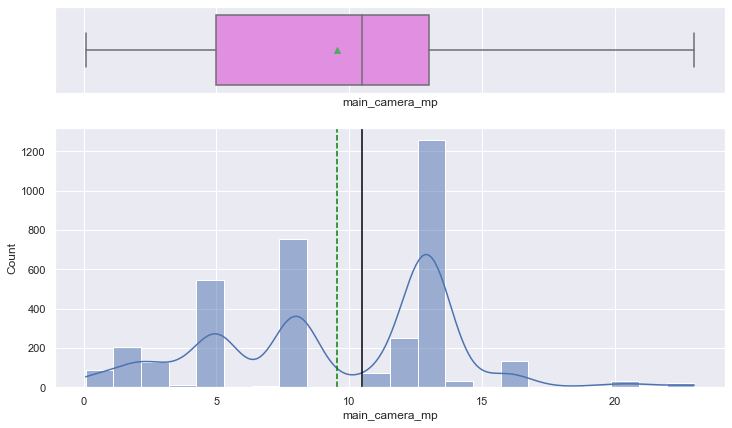

In [267]:
histogram_boxplot(recell_df, 'main_camera_mp', figsize=(12, 7), kde=True, bins=None)

### Verify that outliers have been treated

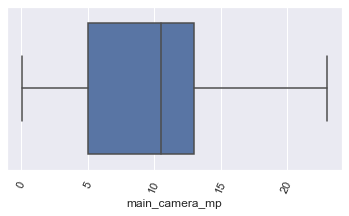

In [268]:

plt.figure(figsize=(6,3))
sns.boxplot(recell_df['main_camera_mp'])
plt.xticks(rotation=65)
plt.show()

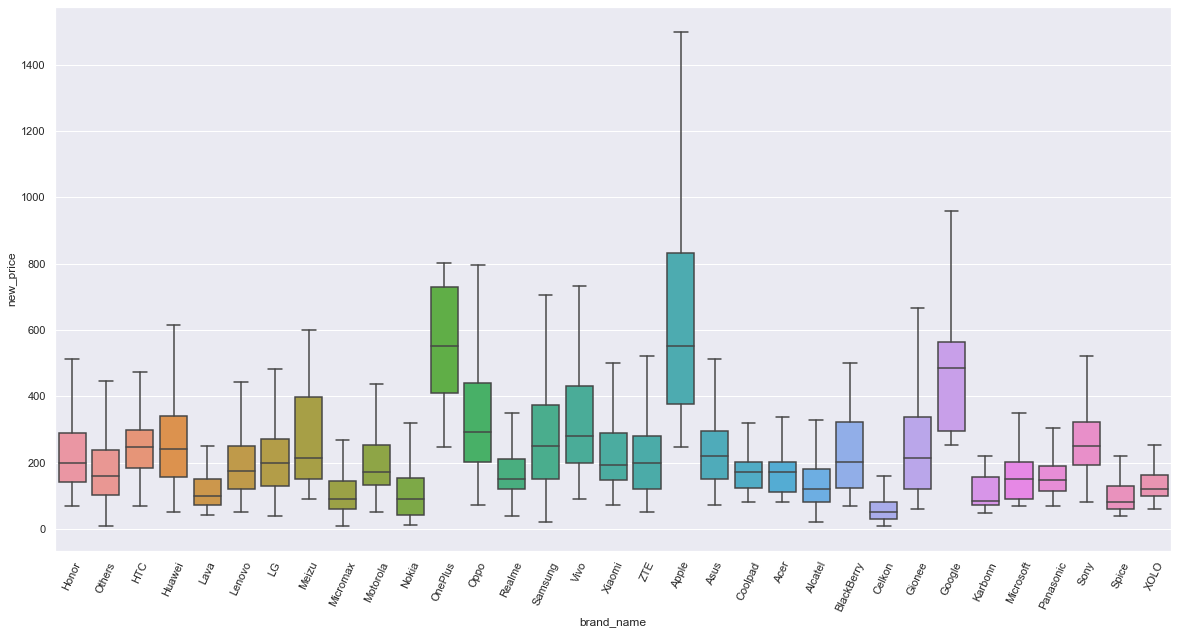

In [269]:
plt.figure(figsize=(20,10))
sns.boxplot(data=recell_df, x=recell_df['brand_name'], y=recell_df['new_price'])
plt.xticks(rotation=65)
plt.show()

### EDA to examine relationship between the predictors and the response variable

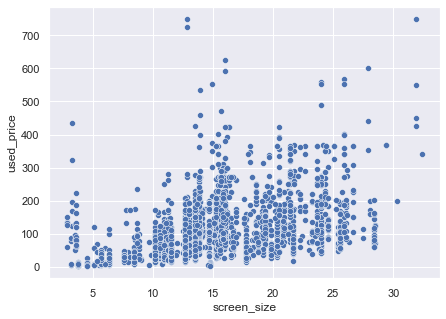

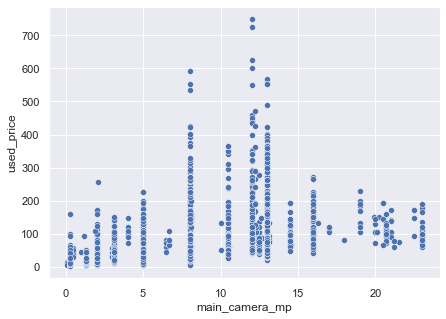

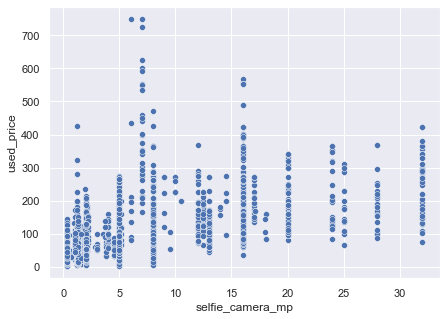

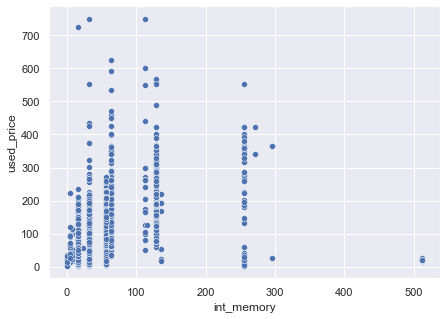

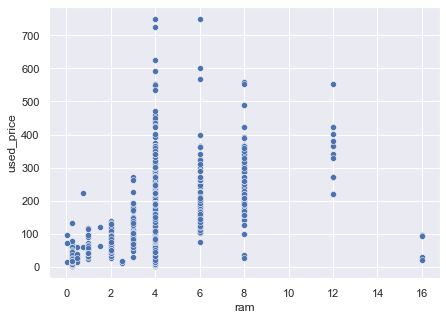

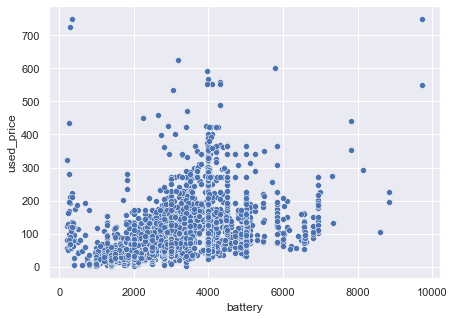

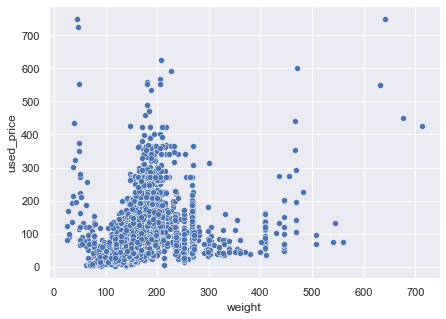

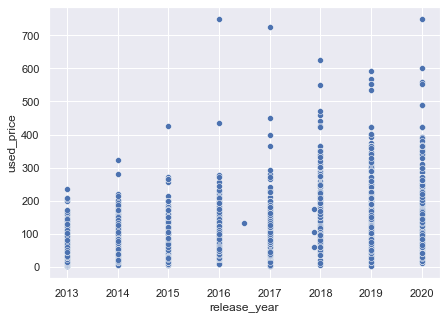

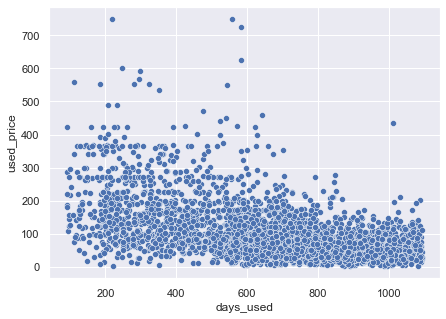

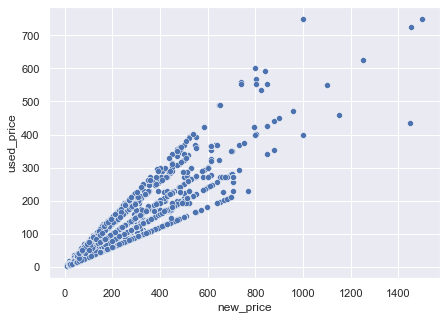

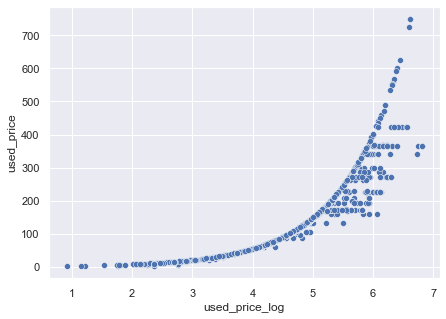

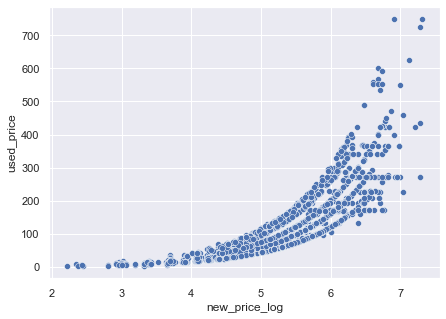

In [270]:
# verify that there is a linear relationship between the continuous independent variables
# and our response variable used_price
for feature in numeric_columns:
    if (feature == 'used_price'):
        continue
    plt.figure(figsize=(7, 5))
    sns.scatterplot(y="used_price", x=feature, data=recell_df)
    plt.show()

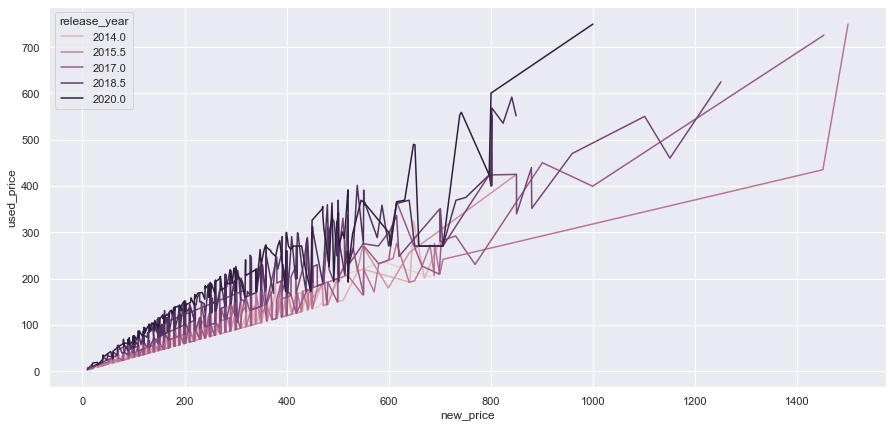

In [271]:
plt.figure(figsize=(15, 7))
sns.lineplot(x="new_price", y="used_price", data=recell_df, hue="release_year", ci=None)
plt.show()

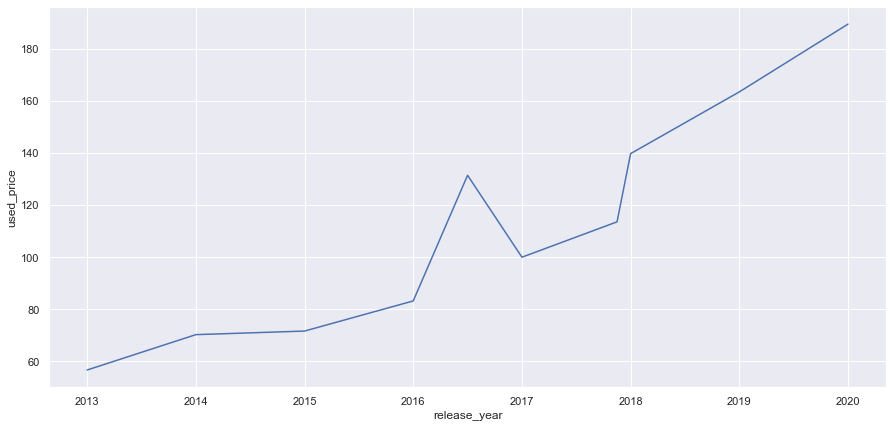

In [272]:
plt.figure(figsize=(15, 7))
sns.lineplot(x="release_year", y="used_price", data=recell_df, ci=None)
plt.show()

### There appears to be somewhat of a linear relationship between the predictors and the response variable however only the new_price and release_year show strong correlation. Besides, the others show a fair amount of undesirable variance.

## Convert object types to categories

In [273]:
recell_df['brand_name'] = recell_df['brand_name'].astype('category')
recell_df['os'] = recell_df['os'].astype('category')
recell_df['4g'] = recell_df['4g'].astype('category')
recell_df['5g'] = recell_df['5g'].astype('category')

In [274]:
recell_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3561 entries, 0 to 3570
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   brand_name        3561 non-null   category
 1   os                3561 non-null   category
 2   screen_size       3561 non-null   float64 
 3   4g                3561 non-null   category
 4   5g                3561 non-null   category
 5   main_camera_mp    3561 non-null   float64 
 6   selfie_camera_mp  3561 non-null   float64 
 7   int_memory        3561 non-null   float64 
 8   ram               3561 non-null   float64 
 9   battery           3561 non-null   float64 
 10  weight            3561 non-null   float64 
 11  release_year      3561 non-null   float64 
 12  days_used         3561 non-null   float64 
 13  new_price         3561 non-null   float64 
 14  used_price        3561 non-null   float64 
 15  used_price_log    3561 non-null   float64 
 16  new_price_log     3561 n

##  MinMaxScaler and Standard transformations to the numerical features was simulated in order to compare coefficients on the same scale.

In [275]:
#recell_df[numerical_col] = MinMaxScaler().fit_transform(recell_df[numerical_col])

In [276]:
#recell_df[numerical_col] = StandardScaler().fit_transform(recell_df[numerical_col])

### The heatmap is to show correlations between numeric variables. Particularly high correlation of predictors can add to variance inflation factor VIF. Predictor features like days_used and release_year are highly correlated. Moreover, days_used take into account release_year and hence it is illadvisable to use both.


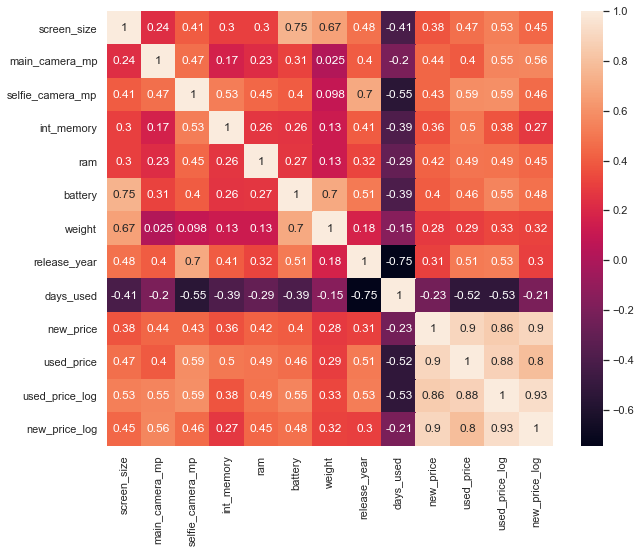

In [277]:
plt.figure(figsize=(10,8))
sns.heatmap(recell_df.corr(), annot=True)
plt.show()

## Building a Linear Regression model

In [278]:
# defining X and y variables
# X is the list of our independent or predictors variables
X = recell_df.drop(["new_price", "used_price", "used_price_log"], axis=1)
# y is our dependent or response variable
y = recell_df["used_price_log"]

In [279]:
X = pd.get_dummies(
    X,
    columns=X.select_dtypes(include=["object", "category"]).columns.tolist(),
    drop_first=True,
)
X.head(10)

,screen_size,main_camera_mp,selfie_camera_mp,int_memory,ram,battery,weight,release_year,days_used,new_price_log,...,brand_name_Spice,brand_name_Vivo,brand_name_XOLO,brand_name_Xiaomi,brand_name_ZTE,os_Others,os_Windows,os_iOS,4g_yes,5g_yes
0,23.97,13.0,5.0,64.0,3.0,3020.0,146.0,2020.0,127.0,4.715100,...,0,0,0,0,0,0,0,0,1,0
1,28.10,13.0,16.0,128.0,8.0,4300.0,213.0,2020.0,325.0,5.519018,...,0,0,0,0,0,0,0,0,1,1
2,24.29,13.0,8.0,128.0,8.0,4200.0,213.0,2020.0,162.0,5.884631,...,0,0,0,0,0,0,0,0,1,1
3,26.04,13.0,8.0,64.0,6.0,5470.0,231.0,2020.0,345.0,5.630961,...,0,0,0,0,0,0,0,0,1,1
4,15.72,13.0,8.0,64.0,3.0,5000.0,185.0,2020.0,293.0,4.947837,...,0,0,0,0,0,0,0,0,1,0
5,21.43,13.0,8.0,64.0,4.0,4000.0,176.0,2020.0,223.0,5.060694,...,0,0,0,0,0,0,0,0,1,0
6,19.84,13.0,5.0,32.0,2.0,3020.0,144.0,2020.0,234.0,4.518958,...,0,0,0,0,0,0,0,0,1,0
7,18.57,13.0,8.0,64.0,4.0,3400.0,164.0,2020.0,219.0,5.188726,...,0,0,0,0,0,0,0,0,1,0
8,15.72,13.0,16.0,128.0,6.0,4000.0,165.0,2020.0,161.0,5.299916,...,0,0,0,0,0,0,0,0,1,0
9,21.43,13.0,8.0,128.0,6.0,4000.0,176.0,2020.0,327.0,5.073610,...,0,0,0,0,0,0,0,0,1,0


In [280]:
# dropping liability features that are not improving the model
# these numeric features have been selected for dropping by iterative testing

X = X.drop(['battery', 'weight', 'release_year', 'os_iOS'], axis=1)

In [281]:
# initialize drop list
# features with p-values higher than our 0.05 significance level will be listed for dropping
# after first model simulation
if dropped == False:
    drop_list = []

In [282]:
# The drop list earmarks features that have low statistical significance for elimination
# The process is still trial and error because the coefficient as well as p-values change
# as the predictor set changes

if (len(drop_list) > 0):
    X = X.drop(drop_list, axis=1)
    drop_list.clear()
else:
    print("Did not drop list")


In [283]:
# splitting the data in 70:30 ratio for train to test data
# also we set a random seed so that whenever we repeat this step
# we get the same result

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [284]:
# Initialize sklearn linear regression object
lnregression = LinearRegression()
# compute our best fit line using the training data set
lnregression.fit(x_train, y_train)

LinearRegression()

In [285]:
x_train.shape
x_test.shape

(1069, 6)

In [286]:
# get the coefficients of the best-fit linear function
coef_df = pd.DataFrame(
    np.append(lnregression.coef_, lnregression.intercept_),
    index=x_train.columns.tolist() + ["Intercept"],
    columns=["Coefficients"],
)

coef_df

,Coefficients
screen_size,0.001592
main_camera_mp,0.000708
selfie_camera_mp,0.001173
int_memory,0.000151
days_used,-0.001111
new_price_log,0.984894
Intercept,-0.094021


## Model performance evaluation - For simple multiple linear regression

In [287]:
# function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mape_score(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

In [288]:
# checking model performance on train set (seen 70% data)
print("Training Performance\n")
linearregression_train_perf = model_performance_regression(
    lnregression, x_train, y_train
)
linearregression_train_perf

Training Performance



,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.088688,0.072198,0.988179,0.988151,1.746066


In [289]:
# checking model performance on test set (other 30% data)
print("Test Performance\n")
linearregression_test_perf = model_performance_regression(
    lnregression, x_test, y_test
)
linearregression_test_perf

Test Performance



,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.090199,0.074577,0.987445,0.987375,1.825667


## Linear Regression using statsmodels¶
### Let's build a linear regression model using statsmodels.

In [290]:
# unlike sklearn, statsmodels does not add a constant to the data on its own
# we have to add the constant manually

# adding constant to the train data
x_train1 = sm.add_constant(x_train)
# adding constant to the test data
x_test1 = sm.add_constant(x_test)

olsmod0 = sm.OLS(y_train, x_train1).fit()
summ = olsmod0.summary()
print(summ)

                            OLS Regression Results                            
Dep. Variable:         used_price_log   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 3.462e+04
Date:                Wed, 30 Mar 2022   Prob (F-statistic):               0.00
Time:                        11:16:54   Log-Likelihood:                 2501.2
No. Observations:                2492   AIC:                            -4988.
Df Residuals:                    2485   BIC:                            -4948.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0940      0.016  

In [291]:
# This code is used to generate the drop list for statistically insignificant features
xs =olsmod0.pvalues
drop_list = [xs.index[idx] for idx, pval in enumerate(xs) if ((pval > 0.05) & (idx != 0))]

In [292]:
drop_list

['main_camera_mp']

In [293]:
insample_pred = olsmod0.predict(x_train1)

In [294]:
outsample_pred = olsmod0.predict(x_test1)

## Checking Linear Regression Assumptions

- In order to make statistical inferences from a linear regression model, it is important to ensure that the assumptions of linear regression are satisfied.

In [295]:
# we will define a function to check VIF
def checking_vif(predictors):
    vif = pd.DataFrame()
    vif["feature"] = predictors.columns

    # calculating VIF for each feature
    vif["VIF"] = [
        variance_inflation_factor(predictors.values, i)
        for i in range(len(predictors.columns))
    ]
    return vif

In [296]:
# check for variance inflation using the training data
checking_vif(x_train1)

,feature,VIF
0,const,79.402673
1,screen_size,1.443262
2,main_camera_mp,1.596700
3,selfie_camera_mp,2.199826
4,int_memory,1.475235
5,days_used,1.551938
6,new_price_log,1.759603


### Prediction using out-of-sample data

In [297]:
df_pred = pd.DataFrame()

df_pred["Actual Values"] = y_test  # actual values
df_pred["Fitted Values"] =  outsample_pred # Prediction using out of sample data - predicted values
df_pred["Residuals"] = y_test - outsample_pred # residuals

In [298]:
df_pred.sample(n=20)

,Actual Values,Fitted Values,Residuals
2186,4.785406,4.742868,0.042538
1120,3.781459,3.804399,-0.022940
881,3.589888,3.616127,-0.026240
2264,4.856240,4.961328,-0.105088
1421,3.183456,3.181949,0.001507
2551,4.569854,4.478540,0.091314
1083,4.998765,4.954834,0.043931
2087,3.681099,3.810693,-0.129594
688,4.500254,4.636356,-0.136102
2831,4.789323,4.757194,0.032129


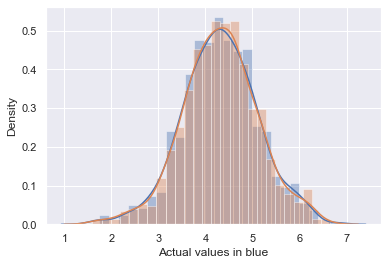

In [299]:
sns.distplot(df_pred['Actual Values'])
sns.distplot(df_pred['Fitted Values'])
plt.xlabel('Actual values in blue')
plt.show()

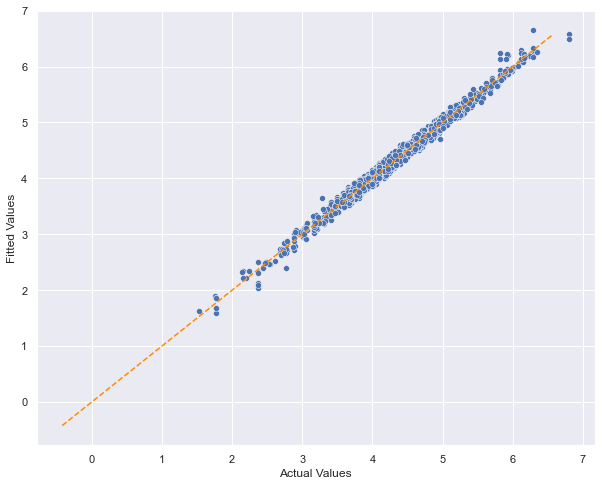

In [300]:
# Plotting the actual vs predicted values
# The orange line represents where the predicted and actual values would lie if they were no errors
# The scatterplot shows the residuals of the regression
# All-in-all there seems to be a slight negative bias in the predicted values
# for larger values as well as large error terms consistent with RMSE, MAE,and MAPE

plt.figure(figsize=(10,8))
sns.scatterplot(x=df_pred['Actual Values'], y=df_pred['Fitted Values'], data=df_pred)
# Plotting the diagonal line
line_coords = np.arange(df_pred.min().min(), df_pred.max().max())
plt.plot(line_coords, line_coords,  # X and y points
         color='darkorange', linestyle='--')
plt.show()

### This scatter plot confirms there is linearity between the predictors and the response variable. If the predicted values coincided perfectly with the actual values, the plot would be the straight diagonal line, however due to errors or randomness, there are residuals resulting in the variation

### The simple model shows a great degree of variation beyond 200 dollars - predicting too high as well as too low values.

<AxesSubplot:xlabel='Fitted Values', ylabel='Residuals'>

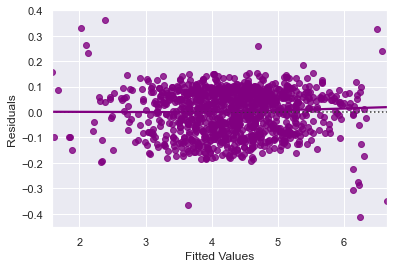

In [301]:
sns.residplot(data=df_pred, x="Fitted Values", y="Residuals", color="purple", lowess=True)

**Observations**

- No observed pattern in the plot above.
- Hence, the assumptions of linearity and independence are satisfied.

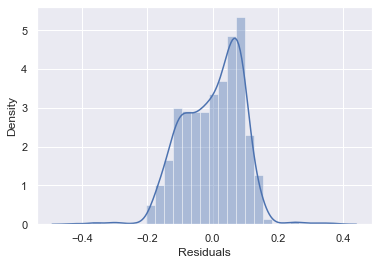

In [302]:
sns.distplot(df_pred['Residuals'])
plt.show()

### The residuals distribution is fairly normal looking - this is more evidence that the predictors themselves have normal distributions. 

## Polynomial terms added to improve the fit

In [303]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

poly = PolynomialFeatures(degree=2, interaction_only=True)
#poly = PolynomialFeatures(degree=2)
x_train2 = poly.fit_transform(x_train)
x_test2 = poly.fit_transform(x_test)

poly_clf = linear_model.LinearRegression()

poly_clf.fit(x_train2, y_train)

y_pred = poly_clf.predict(x_test2)

print(y_pred)

# In sample (training) R^2 will always improve with the number of variables!
print(poly_clf.score(x_train2, y_train))

[4.20683966 4.60657084 3.70572698 ... 4.15980078 4.7109498  4.50864655]
0.9887785008866118


## Model performance evaluation - For model with added polynomial terms

In [304]:
# Out off sample (testing) R^2 is our measure of sucess and does improve
print(poly_clf.score(x_test2, y_test))

0.98821965275722


In [305]:
poly_df_pred = pd.DataFrame()

poly_df_pred["Actual Values"] = y_test  # actual values
poly_df_pred["Fitted Values"] =  y_pred # predicted values
poly_df_pred["Residuals"] = y_test - y_pred # residuals

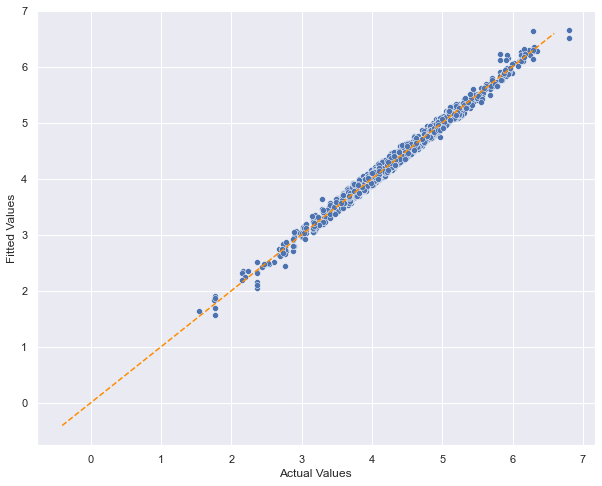

In [306]:
# Plotting the actual vs predicted values
# The orange line represents where the predicted and actual values would lie if they were no errors
# The scatterplot shows the residuals of the regression

plt.figure(figsize=(10,8))
sns.scatterplot(x=poly_df_pred['Actual Values'], y=poly_df_pred['Fitted Values'], data=poly_df_pred)
# Plotting the diagonal line
line_coords = np.arange(poly_df_pred.min().min(), poly_df_pred.max().max())
plt.plot(line_coords, line_coords,  # X and y points
         color='darkorange', linestyle='--')
plt.show()

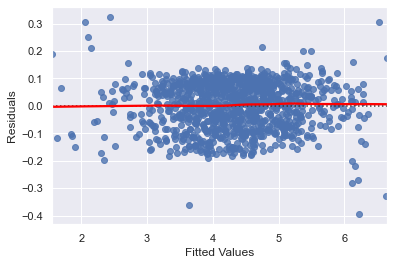

In [307]:
# Plotting the residuals vs predicted values
# The orange line represents where the predicted and actual values would lie if they were no errors
# The scatterplot shows the residuals of the regression

#plt.figure(figsize=(10,8))
sns.residplot(x=poly_df_pred['Fitted Values'], y=poly_df_pred['Residuals'], \
              data=poly_df_pred, lowess=True, line_kws={'color':'red'})
plt.show()

**Observations**

- No observed pattern in the plot above. ie. there is no heteroskedasticity observed even though outliers exist.
- Hence, the assumptions of linearity and independence are satisfied.

In [308]:
# checking model performance on test set (other 30% data)
print("Test Performance\n")
linearregression_test_perf = model_performance_regression(
    poly_clf, x_test2, y_test
)
linearregression_test_perf

Test Performance



,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.087373,0.071998,0.98822,0.987972,1.76407


In [309]:
poly_df_pred.sample(n=15)

,Actual Values,Fitted Values,Residuals
173,4.508439,4.457015,0.051424
2870,3.177637,3.163675,0.013962
756,4.596634,4.492233,0.104401
452,3.985645,3.945954,0.039691
201,5.018802,5.052943,-0.034141
2467,4.939426,5.006182,-0.066756
1619,3.028683,3.097795,-0.069112
1958,3.165053,3.219250,-0.054197
3263,3.331133,3.280008,0.051125
942,2.370038,2.107856,0.262182


### TEST FOR NORMALITY

- We will test for normality by checking the distribution of residuals, by checking the Q-Q plot of residuals, and by using the Shapiro-Wilk test.
- If the residuals follow a normal distribution, they will make a straight line plot, otherwise not.
- If the p-value of the Shapiro-Wilk test is greater than 0.05, we can say the residuals are normally distributed.

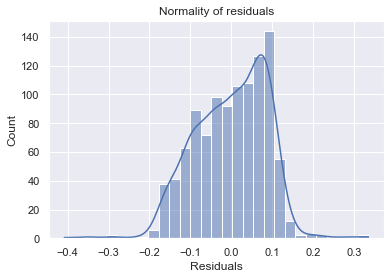

In [310]:
sns.histplot(data=poly_df_pred, x="Residuals", kde=True)
plt.title("Normality of residuals")
plt.show()

**Observations**

- The histogram of residuals does have a slight bell shape.
- Let's check the Q-Q plot.

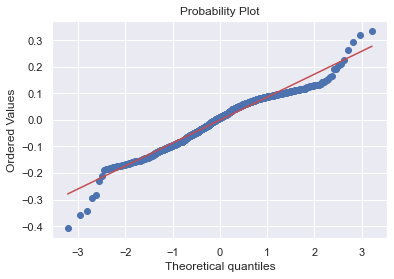

In [311]:
import pylab
import scipy.stats as stats

stats.probplot(poly_df_pred["Residuals"], dist="norm", plot=pylab)
plt.show()

**Observations**

- The residuals more or less follow a straight line except for the tails.
- Let's check the results of the Shapiro-Wilk test.

In [312]:
stats.shapiro(poly_df_pred["Residuals"])

ShapiroResult(statistic=0.9728189706802368, pvalue=2.8606156614492673e-13)

**Observations**

- Since p-value < 0.05, the residuals are not normal as per the Shapiro-Wilk test.
- Strictly speaking, the residuals are not normal. However, as an approximation, we can accept this distribution as close to being normal.
- So, the assumption is satisfied.

TEST FOR HOMOSCEDASTICITY
We will test for homoscedasticity by using the goldfeldquandt test.
If we get a p-value greater than 0.05, we can say that the residuals are homoscedastic. Otherwise, they are heteroscedastic.

In [323]:
# import statsmodels.stats.api as sms
# #import statsmodels.stats.diagnostic as smd
# from statsmodels.compat import lzip

# name = ["F statistic", "p-value"]
# test = sms.het_goldfeldquandt(df_pred["Residuals"], x_train1)
# lzip(name, test)

## The regression "test" results are impressive with either the simple linear model or with added polynomial terms. However, on the first run (ie. with dropped=False), more complexity from the added polynomial terms resulted in a reduced adjusted  R-squared value.


### RMSE	      MAE	        R-squared  Adj. R-squared	MAPE
### 0.135	     0.082	              0.971	           0.604 	          2.012

## On the second run (dropped=True), when statistically insignificant features are dropped, there is an increase in Adjusted R-squared in the model with added polynomial terms, reulting in the best overall results.


### RMSE	     MAE	        R-squared	Adj. R-squared	MAPE
### 0.087	       0.071	         0.988	           0.987	            1.764

## Final Model Summary

## Strategy: Initially simple linear models with single predictors were executed. new_price was idedntified as the most important feature witha high p-value.

### At the end, the battery feature was dropped because its coefficient was approximately zero and the p-value was far higher than the 0.05 significance level

### Similarly the weight feature was dropped because it was statistically insignificant with a p-level far higher than our 0.05 significance level, and its contribution to R-squared was negligible.

### The release_year was dropped because it was statistically insignificant, and because it is highly correlated (0.7 approx) to the days_used, even though the variance inflation factor of the release_year was moderate at approx 4.3

### Dropped os_iOS because it has a high VIF along with a negative coefficient. Interestingly, the performance consequently reduced on the training data, but improved on the test data. R-squared increased and RMSE reduced.

### The conversion of the skewed new_price and used_price to their respective logs resulted in a dramatic improvement of results. It eliminated heteroscedasticity as well as witnessed in dramatically lower RMSE, MAE, R-Squared, and Adjusted R-Squared, as well as MAPE values.

### The treatment of outliers also significantly contributed to the impressive fit and low error values.

## Actionable Insights and Recommendations

### Overall it appears that performance depends a lot on the starting assumptions of linear regression being met. This means that effective modelling and corresponding predictability is heavily dependent on the volume and distribution of data.

### Initially executed the model using the StandardScaler in order to be able compare the impact of each predictor on the target used_price variable.

### The new_price (replaced by new_price_log) and days_used as expected have the most significance on on used_price. At least 70 percent of the variation in used_price results from the original or new price. The value of the phone depreciates in proportion to the number of days used. Even though the coefficient is low in magnitude, the impact will be felt as the number of days increase significantly -- as in three or more digits.

### The Apple, Google, Celkon, and OnePlus brands have the highest positive coefficients, and more likely to command better prices than other brands. They have relatively higher coefficients than the days_used.

### It will be interesting to know why 4G phones have a negative coefficient. Could it be merely the result of this sample, or is it because of the popularity of 5G? It could be evidence of correlation with release_year as well as days_used, since the 5G phones are newer. Perhaps a different price tier could be developed for 4G, excluding 5G data in order to determine its worth without distortion due to 5G.

### The range and quality of data is important because replacement of missing values have a potential to bias the model.

### Some of the EDA revealed multi peak distributions which might suggest mutiple gaussians. Therefore, it might be instructive to develop more than one price model by segmenting the phone by feature criteria such as price. For example the phones could be categorized into groups based on a price tier and feature. This will make pricing more reflective.